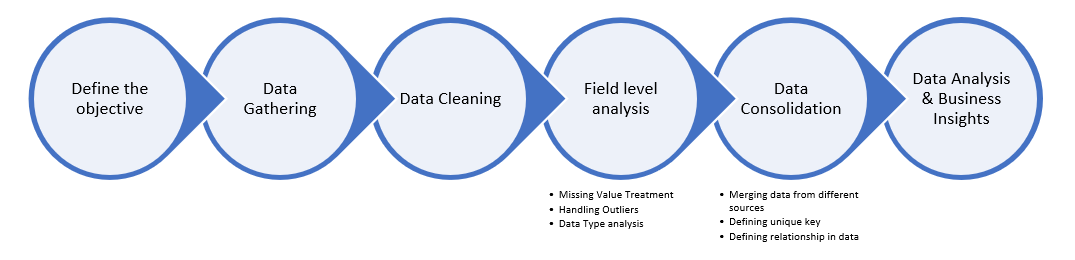[img link](https://)

*  objective is to find out if they will churn or not 
*  data already there
*  data cleaning no null values just making categorical values useful and normalizing

In [0]:
import pandas as pd, numpy as np, seaborn as sns,  matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
churn_data  = pd.read_csv('/content/conversion_data.csv')

<h1>1. general information on data </h1>

In [4]:
churn_data.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [5]:
print ("Rows     : " ,churn_data.shape[0])
print ("Columns  : " ,churn_data.shape[1])
print ("\nFeatures : \n" ,churn_data.columns.tolist())
print ("\nMissing values :  ", churn_data.isnull().sum().values.sum())
print ("\nUnique values :  \n",churn_data.nunique())

Rows     :  316200
Columns  :  6

Features : 
 ['country', 'age', 'new_user', 'source', 'total_pages_visited', 'converted']

Missing values :   0

Unique values :  
 country                 4
age                    60
new_user                2
source                  3
total_pages_visited    29
converted               2
dtype: int64


In [6]:
churn_data.info()
# those that we want as numbers are already numbers

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
country                316200 non-null object
age                    316200 non-null int64
new_user               316200 non-null int64
source                 316200 non-null object
total_pages_visited    316200 non-null int64
converted              316200 non-null int64
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [7]:
churn_data.nunique()

country                 4
age                    60
new_user                2
source                  3
total_pages_visited    29
converted               2
dtype: int64

In [0]:
numerical_features = ['age', 'total_pages_visited']
categorical_features = ['country', 'new_user', 'source']
target ="converted"

<h1>2. Exploring the data</h1>

possible questions:
*  does churn differ by country?
*  impact of age on conversion?
*  impact of visited pages on conversion?
*  is one source more effective than another?



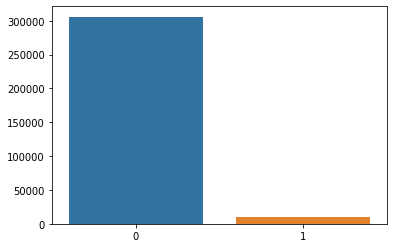

In [9]:
y = churn_data["converted"].value_counts()
sns.barplot(y.index,y.values)

In [10]:
print('we have a conversion rate of {:1.2f}%'.format((y[1]/np.sum(y.values)*100)))

we have a conversion rate of 3.23%


<h3>A. find out the distribution of the numerical categories</h3>

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6df039b7f0>,
      dtype=object)

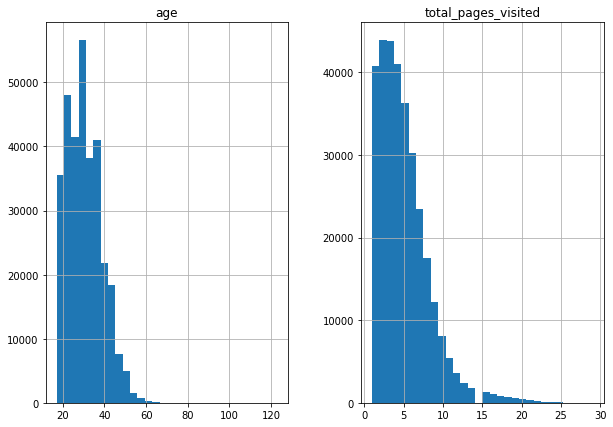

In [11]:
churn_data[numerical_features].hist(bins=30, figsize=(10, 7))

<h3>B. is there a relation between age and churn?</h3>

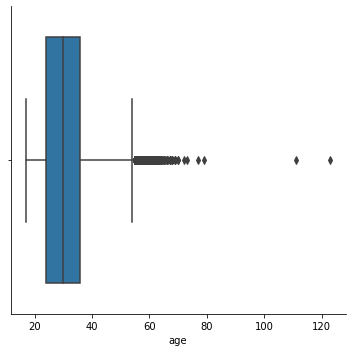

In [12]:
sns.catplot(x="age",  kind="box", data=churn_data)

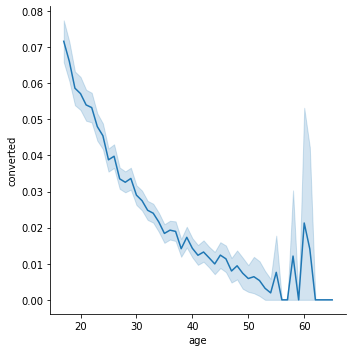

In [13]:
sns.relplot(x="age", y="converted", kind='line', data=churn_data[churn_data.age < 66])

we see a clear linear relationship: we can try to split the ages in groups to avoid overfitting 

In [0]:
def group_age(x):
  if x <= 20:
    return 0
  elif x <= 30:
    return 1
  elif x <= 40:
    return 2
  elif  x <= 50:
    return 3
  else:
    return 4
churn_data["age_groups"] = churn_data.age.apply(lambda x: group_age(x))

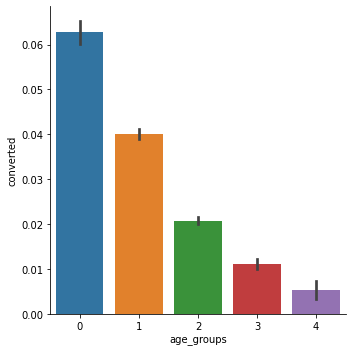

In [15]:
s = sns.catplot(x="age_groups", y="converted", data=churn_data, kind="bar")
cats_ages = churn_data.groupby("age_groups").count()
def plot_conversion_per_group(df, groupedby, sorton):
  newdf = pd.DataFrame(df[[groupedby,sorton]].groupby(groupedby).first())
  newdf = newdf.sort_values(sorton)
  sns.catplot(x=sorton, y=groupedby, kind="bar", data=newdf)



<h3>C. relationship with page visits</h3>

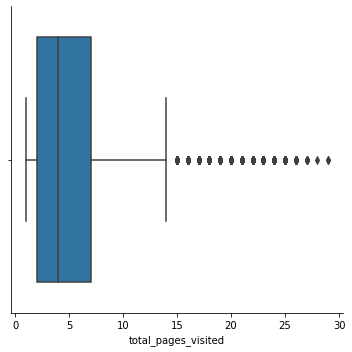

In [16]:
sns.catplot(x="total_pages_visited",  kind="box", data=churn_data)

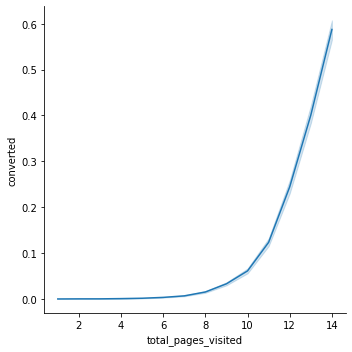

In [17]:
sns.relplot(x="total_pages_visited", y="converted", kind="line", data=churn_data[churn_data.total_pages_visited < 15])

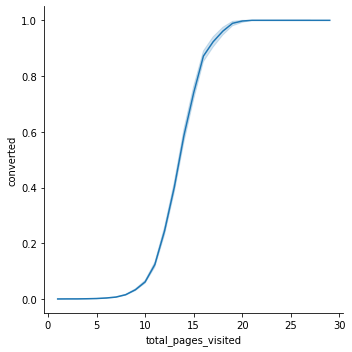

In [18]:
sns.relplot(x="total_pages_visited", y="converted", kind="line", data=churn_data)

*  we see a perfect logistic regression -- logistic regression is probably a good 
idea 

*  the people visitting above 15 pages are almost certainly buying  

In [0]:
 def group_visits(x):
   if x < 5:
     return 0
   elif x < 8:
     return 1
   elif x < 11:
     return 3
   elif x < 15:
     return 4
   else:
     return 5
 churn_data["visit_groups"] = churn_data.total_pages_visited.apply(lambda x: group_visits(x))

In [20]:
churn_data["visit_groups"]

0         0
1         1
2         0
3         1
4         1
         ..
316195    3
316196    1
316197    0
316198    0
316199    0
Name: visit_groups, Length: 316200, dtype: int64

<h3>D. influence of country source and being new user on conversion</h3>

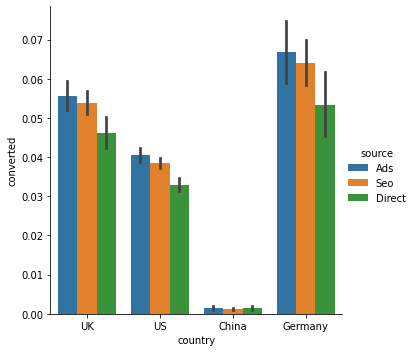

In [21]:
sns.catplot(data=churn_data, x="country", y="converted", kind="bar", hue="source")

in china we see a way lower conversion while in germany we see the highest does this have an underlying reason?
*  different age distribution? 
*  different sources?
*  different page visits? 
*  more old users? 
*  probably question of higher income

age distribution is more or less the same in each country


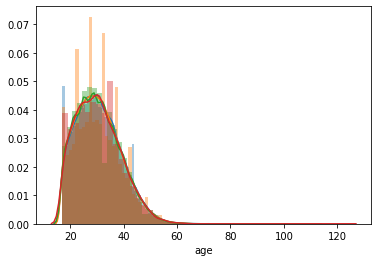

In [22]:
sns.distplot(churn_data[churn_data.country=="China"].age, hist=True, label="china")
sns.distplot(churn_data[churn_data.country=="US"].age, hist=True, label="us")
sns.distplot(churn_data[churn_data.country=="UK"].age, hist=True ,label="uk")
sns.distplot(churn_data[churn_data.country=="Germany"].age, hist=True ,label="germany")
print("age distribution is more or less the same in each country")

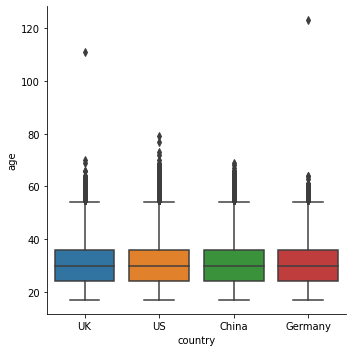

In [23]:
sns.catplot(x="country", y="age",
            kind="box", dodge=False, data=churn_data);

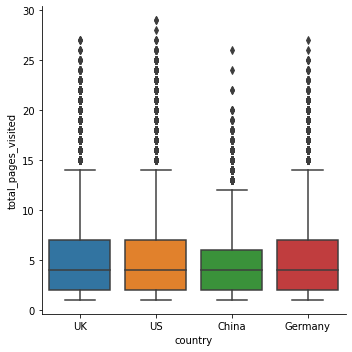

In [24]:
sns.catplot(x="country", y="total_pages_visited",
            kind="box", dodge=False, data=churn_data);

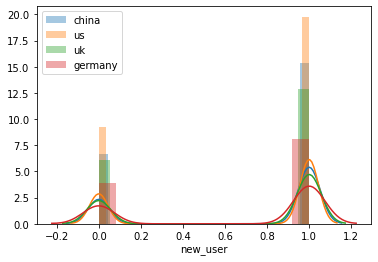

In [25]:
sns.distplot(churn_data[churn_data.country=="China"].new_user,  label="china")
sns.distplot(churn_data[churn_data.country=="US"].new_user,  label="us")
sns.distplot(churn_data[churn_data.country=="UK"].new_user ,label="uk")
sns.distplot(churn_data[churn_data.country=="Germany"].new_user  ,label="germany")
plt.legend()

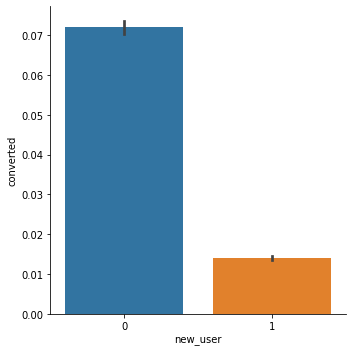

In [26]:
sns.catplot(data=churn_data, x="new_user", y="converted", kind="bar")

relative more new users which convert less but does not justify big difference

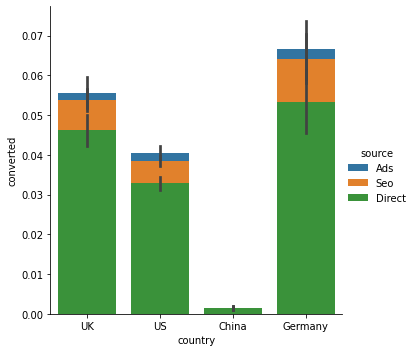

In [27]:
sns.catplot(x="country", y="converted", hue="source", dodge=False, data=churn_data, kind="bar");

In [0]:
df1 = churn_data.groupby("country").sum()
df2 = churn_data.groupby("country").size()

In [0]:
rates_of_new_users_per_country = (df1.iloc[:,1].values)/(df2.values)
rates_of_converted_per_country = (df1.iloc[:,-2].values)/(df2.values)

In [0]:
country_names = df2.index

In [0]:
rates = pd.DataFrame()
rates["country"] = country_names
rates["new_user_rate"] = rates_of_new_users_per_country
rates["conversion_rate"] = rates_of_converted_per_country

In [32]:
rates

,country,new_user_rate,conversion_rate
0,China,0.698520,1.506762
1,Germany,0.677237,1.485294
2,UK,0.679835,1.487513
3,US,0.681985,1.498680


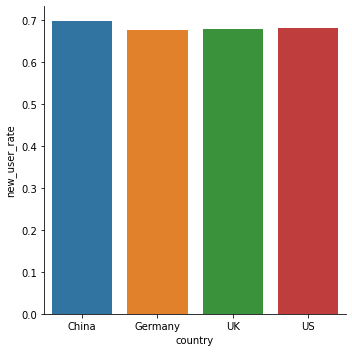

In [33]:
sns.catplot(data=rates, y="new_user_rate", x="country", kind="bar")

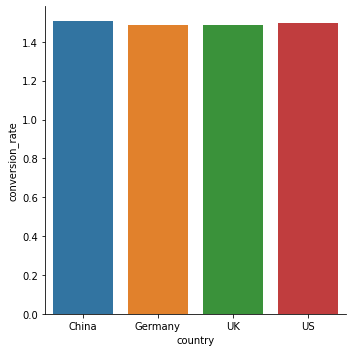

In [34]:
sns.catplot(data=rates, y="conversion_rate", x="country", kind="bar")

chinese come from direct which means slightly less succes in conversion

*  seems like ads work best for churn and germany is the company with most churn 
*  china has a very low churn rate next to this 
*  on first site a custome would be a first visiter from germany coming in via adsand with a low age

<h1>2. Generalizing and scaling the variables</h1>

In [0]:
y_target = [target]
features = categorical_features + [ 'age', 'total_pages_visited'] 

In [0]:
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer

In [0]:
y = churn_data[y_target].values
x = churn_data[features].values

In [0]:
country_ohe = OneHotEncoder(drop='first')
source_ohe = OneHotEncoder(drop='first')

In [0]:
country_encoded = country_ohe.fit_transform(x[:,0].reshape(-1,1)).toarray()
# china is ref first one is ger then uk then us 

In [0]:
source_encoded = source_ohe.fit_transform(x[:,2].reshape(-1,1)).toarray()
# ads is the ref first one is direct then seo

In [0]:
X = np.append(x, source_encoded , axis=1)
X = np.append(country_encoded, X , axis=1)

In [0]:
labels = ['isGer', 'isUK', 'isUS', 'del1', 'isNew', 'del2', 'age', 'visited_pages','isDirect', 'isSeo']

In [43]:
X[1]

array([0.0, 0.0, 1.0, 'US', 1, 'Seo', 23, 5, 0.0, 1.0], dtype=object)

In [0]:
encoded_df = pd.DataFrame(data=X, columns=labels)
encoded_df = encoded_df.drop(columns=['del1','del2'])

In [45]:
encoded_df.head()

,isGer,isUK,isUS,isNew,age,visited_pages,isDirect,isSeo
0,0,1,0,1,25,1,0,0
1,0,0,1,1,23,5,0,1
2,0,0,1,1,28,4,0,1
3,0,0,0,1,39,5,0,1
4,0,0,1,1,30,6,0,1


In [0]:
x = encoded_df.values

In [0]:
from sklearn.model_selection import train_test_split

In [48]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.1, random_state=0, stratify=y)
print("...Done.")


Dividing into train and test sets...
...Done.


In [49]:
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
X_train[:, 4:6]

array([[22, 2],
       [21, 3],
       [20, 14],
       ...,
       [41, 5],
       [31, 4],
       [26, 3]], dtype=object)

In [0]:
# normalize
sc_x  = StandardScaler()
scaler.fit(X_train[:, 4:6])
transformed_x_train = scaler.transform(X_train[:, 4:6])
transformed_x_test = scaler.transform(X_test[:, 4:6])

In [0]:
# without normalization 
transformed_x_train = X_train[:, 4:6]
transformed_x_test = X_test[:, 4:6]

In [52]:
transformed_x_test
X_test

array([[0.0, 1.0, 0.0, ..., 16, 0.0, 1.0],
       [0.0, 1.0, 0.0, ..., 5, 1.0, 0.0],
       [0.0, 0.0, 0.0, ..., 1, 0.0, 1.0],
       ...,
       [0.0, 1.0, 0.0, ..., 5, 0.0, 1.0],
       [0.0, 1.0, 0.0, ..., 14, 0.0, 1.0],
       [0.0, 0.0, 1.0, ..., 2, 0.0, 1.0]], dtype=object)

In [0]:
X_test[:, -3] = transformed_x_test[:, -1]
X_test[:, -4] = transformed_x_test[:, -2]
X_train[:, -3] = transformed_x_train[:, -1]
X_train[:, -4] = transformed_x_train[:, -2]

In [54]:
print(X_test[0])
encoded_df.columns

[0.0 1.0 0.0 0 28 16 0.0 1.0]


Index(['isGer', 'isUK', 'isUS', 'isNew', 'age', 'visited_pages', 'isDirect',
       'isSeo'],
      dtype='object')

In [0]:
from sklearn.linear_model import LogisticRegression

In [56]:
classifier = LogisticRegression()
classifier.fit(X_train, Y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

<h1>3. Performance evaluation</h1>

In [57]:
classifier.score(X_train, Y_train)
 

0.9862323423993253

In [58]:
classifier.score(X_test, Y_test)
 

0.9856419987349778

In [0]:
Y_train_pred = classifier.predict(X_train)
Y_test_pred = classifier.predict(X_test)

In [60]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_test_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     30600
           1       0.85      0.68      0.75      1020

    accuracy                           0.99     31620
   macro avg       0.92      0.84      0.87     31620
weighted avg       0.98      0.99      0.98     31620



In [0]:
from sklearn.metrics import confusion_matrix

In [62]:
# Plot outputs
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

Confusion matrix on train set : 
[[274337   1063]
 [  2855   6325]]

Confusion matrix on test set : 
[[30473   127]
 [  327   693]]



In [0]:
from sklearn.utils.multiclass import unique_labels
class_names=[0,1]

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    fig, ax = plt.subplots(figsize=(5, 5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if i == 1:
              x = i - 0.3
            else:
              x = i + 0.3 # because the display is shitty 
            ax.text(j, x, format(cm[i, j], fmt),
                    ha="center", va="center_baseline", 
                    color="white" if cm[i, j] > thresh else "black")
    # fig.tight_layout()
    return ax


np.set_printoptions(precision=10)

Normalized confusion matrix


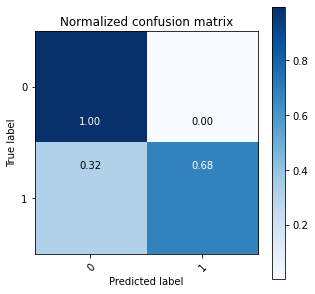

In [65]:
plot_confusion_matrix(Y_test, Y_test_pred, classes=class_names, normalize=True)
# accuracy changed from 68 to 69 with leaving out normalization

from here on spaghetti code 

<h1>try a random forest and gridsearch</h1>


In [0]:
from sklearn import tree

In [0]:
# print("Dividing into train and test sets...")
# X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3, random_state=0, stratify=y)
# print("...Done.")

In [68]:
clf_gini = tree.DecisionTreeClassifier(criterion='gini')
clf_gini.fit(X_train, Y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [69]:
clf_gini.score(X_test, Y_test)

0.9840923466160658

In [0]:
Y_train_pred_rf = clf_gini.predict(X_train)
Y_test_pred_rf = clf_gini.predict(X_test)

In [71]:
print(classification_report(Y_test, Y_test_pred_rf))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     30600
           1       0.83      0.64      0.72      1020

    accuracy                           0.98     31620
   macro avg       0.91      0.82      0.86     31620
weighted avg       0.98      0.98      0.98     31620



In [0]:
from sklearn.ensemble import RandomForestClassifier

In [0]:
from sklearn.model_selection import GridSearchCV

In [0]:
clf_new = RandomForestClassifier()

In [75]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 100, num = 2)]
# Number of features to consider at every split
max_features = ['auto']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 30, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [ 5, 6]
# Minimum number of samples required at each leaf node
min_samples_leaf = [4, 6, 10]
# Method of selecting samples for training each tree
bootstrap = [True]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid, sep="\n")

{'n_estimators': [1, 100], 'max_features': ['auto'], 'max_depth': [1, 8, 15, 22, 30, None], 'min_samples_split': [5, 6], 'min_samples_leaf': [4, 6, 10], 'bootstrap': [True]}


In [76]:
rf_random = RandomizedSearchCV(estimator = clf_new, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, Y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.2min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [83]:
best_random_estimator = rf_random.best_estimator_
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 22,
 'max_features': 'auto',
 'min_samples_leaf': 10,
 'min_samples_split': 5,
 'n_estimators': 100}

In [96]:
y_predictions_best_random_test = best_random_estimator.predict(X_test)
y_predictions_best_random_train = best_random_estimator.predict(X_train)
print(best_random_estimator.score(X_test, Y_test), 'score on best randomly generated one')

0.9854206198608476 score on best randomly generated one


In [97]:
print(classification_report(Y_test, y_predictions_better_random_test))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     30600
           1       0.85      0.68      0.75      1020

    accuracy                           0.99     31620
   macro avg       0.92      0.84      0.87     31620
weighted avg       0.98      0.99      0.98     31620



In [99]:
print(classification_report(Y_test, y_predictions_best_random_test))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     30600
           1       0.84      0.68      0.75      1020

    accuracy                           0.99     31620
   macro avg       0.91      0.84      0.87     31620
weighted avg       0.98      0.99      0.98     31620



<h1>try gridsearch logistic 

In [0]:
from sklearn.model_selection import GridSearchCV

In [0]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-4, 4, 10),
    'solver' : ['liblinear'],
}
# Create a based model
new_log = LogisticRegression()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = new_log, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [82]:
grid_search.fit(X_train, Y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   43.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.3min finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=3, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([1.0000000000e-04, 7.7426368268e-04, 5.9948425032e-03,
       4.6415888336e-02, 3.5938136638e-01, 2.7825594022e+00,
       2.1544346900e+01, 1.6681005372e+02, 1.2915496650e+03,
       1.0000000000e+04]),
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             pre_dispatch='2*n_jobs', 

In [0]:
even_better_estimator = grid_search.best_estimator_

In [88]:

y_predictions_better_random = even_better_estimator.predict(X_train)
y_predictions_better_random_test = even_better_estimator.predict(X_test)
print(even_better_estimator.score(X_test, Y_test), 'score on better randomly generated one')

0.9857052498418722 score on better randomly generated one


In [89]:
print(classification_report(Y_test, y_predictions_better_random_test))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     30600
           1       0.85      0.68      0.75      1020

    accuracy                           0.99     31620
   macro avg       0.92      0.84      0.87     31620
weighted avg       0.98      0.99      0.98     31620



<h1>performance assesment</h1>

In [0]:
from sklearn.metrics import f1_score

In [91]:
# Here, the f1-score will be used to assess the performances on the leaderboard
print("f1-score on train set : ", f1_score(Y_train, y_predictions_better_random ))
print("f1-score on test set : ", f1_score(Y_test, y_predictions_better_random_test))

f1-score on train set :  0.7635990833433842
f1-score on test set :  0.7546145494028231


In [92]:
# You can also check more performance metrics to better understand what your model is doing
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

Confusion matrix on train set : 
[[274337   1063]
 [  2855   6325]]

Confusion matrix on test set : 
[[30473   127]
 [  327   693]]

